# 03: Back Propagation


In [496]:
from copy import deepcopy
from math import prod

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

![](../img/03_forward_backward.png)

The training loop for a neural network involves:

1. A **forward pass**: Feed the input features ($x_1$, $x_2$) through all the layers of the network to compute our predictions, $\hat{y}$.

2. Compute the **loss** (or cost), $\mathcal{L}(y, \hat{y})$, a function of the predicted values $\hat{y}$ and the actual values $y$.

3. A **backward pass** (or _back propagation_): Feed the loss $\mathcal{L}$ back through the network to compute the rate of change of the loss (i.e. the derivative) with respect to the network parameters (the weights and biases for each node, $w$, $b$)

4. Given their derivatives, update the network parameters ($w$, $b$) using an algorithm like gradient descent.

## Forward Pass: Recap

Each node computes a linear combination of the output of all the nodes in the previous layer, for example:

$$
z_1^{[1]} = w_{1 \rightarrow 1}^{[1]} x_1 + w_{2 \rightarrow 1}^{[1]} x_2 + b_1^{[1]}
$$

This is passed to an activation function, $g$, (assumed to be the same function in all layers here), to create the final output, or "activation", of each node:

$$
a_3^{[2]} = g(z_3^{[2]})
$$

For example, $\hat{y}$, can be expressed in terms of the activation of the final layer as follows:

$$
\hat{y} = a_1^{[3]} = g\left(w_{1 \rightarrow 1}^{[3]} a_{1}^{[2]} + w_{2 \rightarrow 1}^{[3]} a_{2}^{[2]} + w_{3 \rightarrow 1}^{[3]} a_{3}^{[2]} + b_1^{[3]}\right)
$$

The terms not introduced above mean:

- $w_{j \rightarrow k}^{[l]}$: The weight between node $j$ in layer $l-1$ and node $k$ in layer $l$.
- $a_k^{[l]}$: The activation of node $k$ in layer $l$
- $b_k^{[l]}$: The bias term for node $k$ in layer $l$

## Learning the Parameters (how not to do it)


Let's consider a simpler network, with one input, two hidden nodes, and one output:

![](../img/03_backprop_example_params.png)

Here I've also included a node after the network's output to represent the calculation of the loss, $\mathcal{L}(y, \hat{y})$, where $\hat{y} = g(z_1^{[2]})$ is the predicted value from the network and $y$ the true value.

This network has seven parameters: $w_1^{[1]}$, $w_2^{[1]}$, $b_1^{[1]}$, $b_2^{[1]}$, $w_1^{[2]}$, $w_2^{[2]}$, $b_1^{[2]}$

How can we learn suitable values for all these parameters?

Let's consider a partially trained network with the example architecture above, using sigmoid activation and log loss, to learn to classify points which belong to one class if $-0.5 < x < 0.5$ and to another class otherwise:

Original loss: 12.017


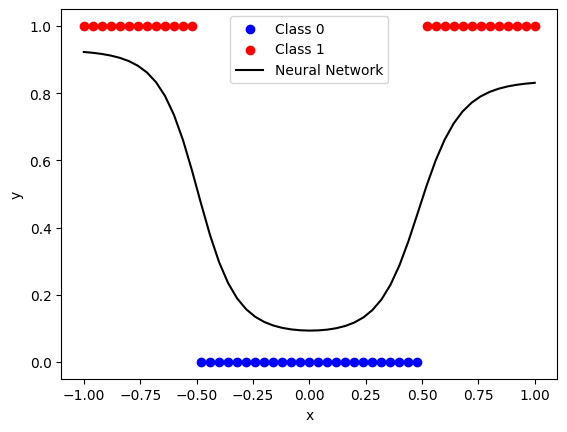

In [495]:
def sigmoid(X):
    return 1 / (1 + np.exp(-X))


class Network:
    def __init__(self, weights, biases, X, y):
        self.weights = weights
        self.biases = biases
        self.X = X
        self.y = y

    def forward(self):
        A = deepcopy(self.X)  # stores activations from previous layer
        for l in range(len(self.weights)):  # iterate over layers
            Z = self.weights[l] @ A + self.biases[l]
            A = sigmoid(Z)
        return A

    def loss(self):
        # log loss
        yhat = self.forward()
        return - (1 / len(self.y)) * (self.y * np.log(yhat) + (1 - self.y) * np.log(1 - yhat)).sum()

    def plot(self):
        plt.scatter(X[y==0], y[y==0], c="b", label="Class 0")
        plt.scatter(X[y==1], y[y==1], c="r", label="Class 1")
        plt.plot(X.T, network.forward().T, color="k", label="Neural Network")
        plt.legend()
        plt.xlabel("x")
        plt.ylabel("y")


n = 51
X = np.linspace(-1, 1, 51).reshape(1, n)
y = ((X < -0.5) | (X > 0.5)).reshape(1, n)

weights = [np.array([-7.8751, -8.3499]).reshape(2, 1), np.array([5.0297, -4.0937]).reshape(1, 2)]
biases = [np.array([-3.9181, 3.8380]).reshape(2, 1), np.array([1.6347]).reshape(1, 1)]
network = Network(weights, biases, X, y)
network.plot()

print(f"Original loss: {network.loss():.3f}")

We learn good values for the parameters iteratively. At each iteration, we ask the question - in what direction should each parameter be adjusted to reduce the loss?

In gradient descent we use the partial derivative of the loss function with respect to the parameters to update the network, making small changes to the parameters like:

$$
w_1^{[1]}  = w_1^{[1]} - \alpha\frac{\partial \mathcal{L}}{\partial w_1^{[1]}}
$$

where $\alpha$ is the learning rate.

One way to estimate this is to compute the loss for a range of $w_1^{[1]}$ values around its initial value, leaving the values of all the other parameters fixed:

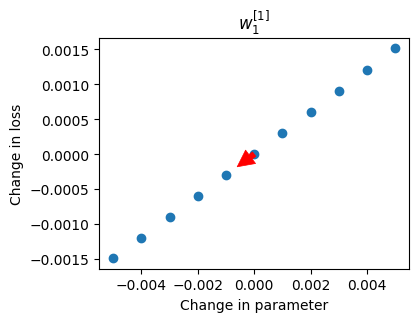

In [487]:
def perturb(network, layer_idx, node_idx, param_type, deltas=np.linspace(-0.005, 0.005, 11)):
    losses = np.full(len(deltas), np.nan)
    for delta_idx, d in enumerate(deltas):
        n = deepcopy(network)
        if param_type == "weight":
            if layer_idx == 0:
                n.weights[layer_idx][node_idx] += d
            else:
                n.weights[layer_idx][0, node_idx] += d
        else:
            n.biases[layer_idx][node_idx] += d
        losses[delta_idx] = n.loss()

    return deltas, losses
    

def plot_perturb(layer_idx, node_idx, param_type, deltas, losses, ax=None, lr=0.002):
    if ax is None:
        _, ax = plt.subplots(figsize=(4, 3))
    orig_loss = network.loss()
    ax.plot(deltas, losses - orig_loss, "o")
    if param_type == "weight":
        symbol = "w"
    else:
        symbol = "b"
    title_str = rf"${symbol}_{node_idx + 1}" + r"^{[" + f"{layer_idx + 1}" + r"]}$"
    ax.set_title(title_str)
    ax.set_xlabel("Change in parameter")
    ax.set_ylabel("Change in loss")
    
    coef = np.polyfit(deltas, losses - network.loss(), 1)
    dx = -coef[0] * lr
    dy = dx * coef[0]
    ann = ax.annotate("", xy=(dx, dy), xytext=(0, 0), arrowprops=dict(linewidth=0.5, color="r"), annotation_clip=False)
    ann.arrow_patch.set_clip_box(ax.bbox)
    return dx


layer_idx = 0
node_idx = 0
param_type = "weight"
deltas, losses = perturb(network, layer_idx, node_idx, param_type)
plot_perturb(layer_idx, node_idx, param_type, deltas, losses);

Each blue point represents the change in the loss (on the whole dataset) for a change in $w_1^{[1]}$. The red arrow shows the recommended change to make to the parameter value in this iteration, in this case decreasing its value (like rolling a ball down a hill).

To perform gradient descent for the whole network we need the derivatives for each parameter, i.e. we need to compute:

$$
\frac{\partial \mathcal{L}}{\partial w_1^{[1]}},
\frac{\partial \mathcal{L}}{\partial w_2^{[1]}},
\frac{\partial \mathcal{L}}{\partial b_1^{[1]}},
\frac{\partial \mathcal{L}}{\partial b_2^{[1]}},
\frac{\partial \mathcal{L}}{\partial w_1^{[2]}},
\frac{\partial \mathcal{L}}{\partial w_2^{[2]}},
\frac{\partial \mathcal{L}}{\partial b_1^{[2]}}
$$

We can repeat the same procedure, computing the loss for several values of the parameter of interest whilst leaving all the others fixed:

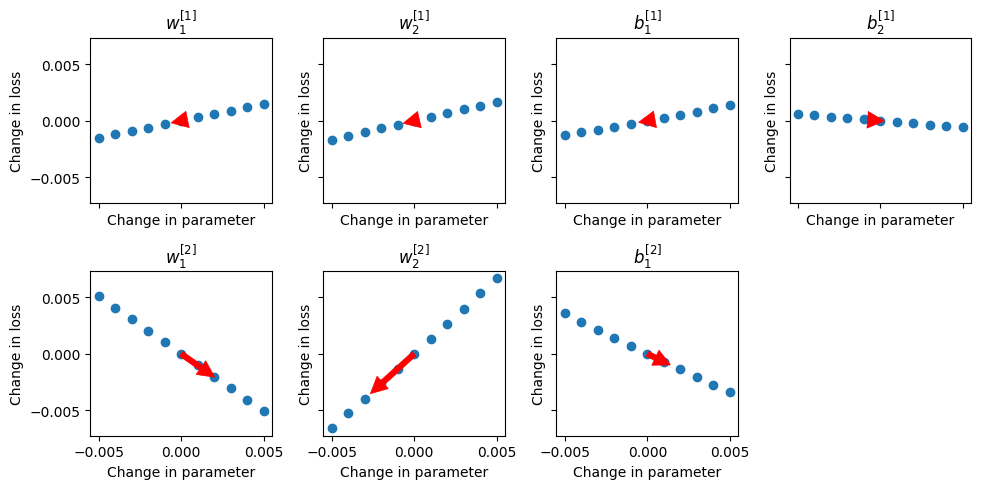

In [488]:
layer_idx = [0, 0, 0, 0, 1, 1, 1]
node_idx = [0, 1, 0, 1, 0, 1, 0]
param_type = ["weight", "weight", "bias", "bias", "weight", "weight", "bias"]
fig, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = ax.flatten()

shifts = []
for idx, layer, node, param in zip(range(len(layer_idx)), layer_idx, node_idx, param_type):
    deltas, losses = perturb(network, layer, node, param)
    param_shift = plot_perturb(layer, node, param, deltas, losses, ax=ax[idx])
    shifts.append(param_shift)
    
ax[-1].axis("off")
fig.tight_layout()

After one iteration, making the changes to the parameters indicated by the red arrows above, the loss is reduced slightly:

In [490]:
new_network = deepcopy(network)
for idx, layer, node, param in zip(range(len(layer_idx)), layer_idx, node_idx, param_type):
    if param == "weight":
        if layer == 0:
            new_network.weights[layer][node] += shifts[idx]
        else:
            new_network.weights[layer][0, node] += shifts[idx]
    else:
        new_network.biases[layer][node] += shifts[idx]

        
print(f"Original loss: {network.loss():.3f}\nNew Loss: {new_network.loss():.3f}")

Original loss: 12.017
New Loss: 12.010


Or after many iterations (thousands):

Trained network loss: 0.347


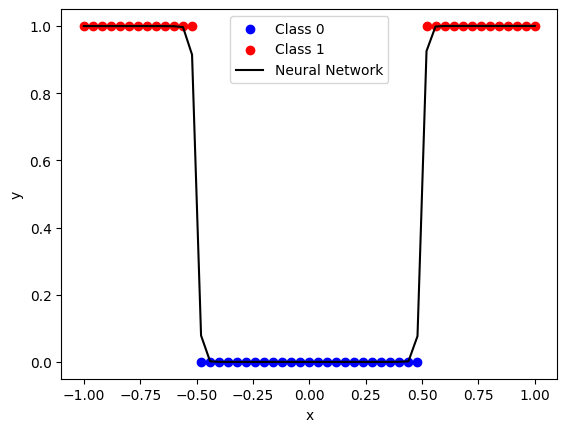

In [491]:
weights = [np.array([27.6292, 29.6453]).reshape(2, 1), np.array([18.5647, -16.8853]).reshape(1, 2)]
biases = [np.array([-13.8410, 14.6499]).reshape(2, 1), np.array([7.7300]).reshape(1, 1)]
network = Network(weights, biases, X, y)
print(f"Trained network loss: {network.loss():.3f}")

network.plot()

This works but it's incredibly inefficient. For each parameter in the network we're computing the loss multiple times, which could be thousands, millions or even billions of times for larger networks (per iteration of gradient descent!)

## Neural Network as a Composed Function

Neural networks are a big composed function (each layer is a function of the output of the previous layer):

![](../img/03_backprop_composedfunction.png)

You might remember that calculating the derivative of composed functions is what the chain rule is for in calculus. Here's a reminder:

## Chain Rule Case 1: $f$ is a function of $g$, and $g$ is a function of $x$

$$
f = f(g(x))
$$

The chain rule states that the derivative of $w$ with respect to $x$ is given by:

$$
\frac{\mathrm{d} f}{\mathrm{d}x} = \frac{\mathrm{d} f}{\mathrm{d} g} \frac{\mathrm{d} g}{\mathrm{d} x}
$$

#### Intuition

> "If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man."
>
> _George F. Simmons, Calculus with Analytic Geometry (1985), p. 93_

Or, in the form of the notation above:

$$
\frac{\mathrm{d} (\mathrm{car})}{\mathrm{d} (\mathrm{bicycle})} = 2 \\
\frac{\mathrm{d} (\mathrm{bicycle})}{\mathrm{d} (\mathrm{walker})} = 4 \\
\frac{\mathrm{d} (\mathrm{car})}{\mathrm{d} (\mathrm{walker})} =
\frac{\mathrm{d} (\mathrm{car})}{\mathrm{d} (\mathrm{bicycle})} \frac{\mathrm{d} (\mathrm{bicycle})}{\mathrm{d} (\mathrm{walker})}
= 2 \times 4 = 8
$$

or we could use $f$ as the car, $g$ as the bicycle, and $x$ as the walking man.

#### Example

Find the derivative of $f(x) = (e^x + x)^2$:

Let:

$$
g(x) = e^x + x \\
f(g) = g^2 \\
$$

Then by chain rule:

$$
\frac{\mathrm{d} f}{\mathrm{d} g} = 2g \\
\frac{\mathrm{d} g}{\mathrm{d} x} = e^x + 1 \\
\frac{\mathrm{d} f}{\mathrm{d}x} = \frac{\mathrm{d} f}{\mathrm{d} g} \frac{\mathrm{d} g}{\mathrm{d} x} = 2g(e^x + 1) \\
\frac{\mathrm{d} f}{\mathrm{d}x} = 2(e^x + x)(e^x + 1) 
$$

## Back Propagation

Back propagation is using the chain rule to compute the rate of change of the loss with the parameter values.

Here's the example network again, but with each edge (arrow) labeled by the partial derviative between the two connected nodes:

![](../img/03_backprop_example_diffs.png)

To compute the derivative of the loss with respect to any term in the network we can use the chain rule. Starting with the loss on the right, we move "backwards" through the network, multiplying the partial derivatives until we get to the term we want.

### Example 1: Computing the gradient for $\color{blue}{b_1^{[2]}}$

Why the chain rule/why multiply backwards along arrows?

- $\color{red}{\mathcal{L}}$ is a function of $\color{green}{a_1^{[2]}}$,  $\color{green}{a_1^{[2]}}$ is a function of $\color{violet}{z_1^{[2]}}$, and $\color{violet}{z_1^{[2]}}$ is a function of $\color{blue}{b_1^{[2]}}$
- We could write that like $\color{red}{\mathcal{L}}\left(\color{green}{a_1^{[2]}}\left(\color{violet}{z_1^{[2]}}\left(\color{blue}{b_1^{[2]}}\right)\right)\right)$, which has the form of "case 1" of the chain rule above except with 3 functions instead of 2, i.e. a composed function like $f\left(g\left(h\left(x\right)\right)\right)$

So, applying the chain rule and multiplying derivatives backwards along the diagram:

$$
\frac{\color{red}{\partial \mathcal{L}}}{\color{blue}{\partial b_1^{[2]}}} = \frac{\color{violet}{\partial z_1^{[2]}}}{\color{blue}{\partial b_1^{[2]}}} \frac{\color{green}{\partial a_1^{[2]}}}{\color{violet}{\partial z_1^{[2]}}} \frac{\color{red}{\partial \mathcal{L}}}{\color{green}{\partial a_1^{[2]}}}
$$

Log loss for one data point (remembering that $\hat{y} = \color{green}{a_1^{[2]}}$):

$$
\color{red}{\mathcal{L}} = - y \log(\color{green}{a_1^{[2]}}) - (1 - y)\log(1 - \color{green}{a_1^{[2]}}) \\
\frac{\color{red}{\partial \mathcal{L}}}{\color{green}{\partial a_1^{[2]}}} = -\frac{y}{\color{green}{a_1^{[2]}}} + \frac{1-y}{1-\color{green}{a_1^{[2]}}}
$$

If using a sigmoid activation function:

$$
\color{green}{a_1^{[2]}} = \frac{1}{1+\exp(-\color{violet}{z_1^{[2]}})} \\
\frac{\color{green}{\partial a_1^{[2]}}}{\color{violet}{\partial z_1^{[2]}}} = \color{green}{a_1^{[2]}} (1 - \color{green}{a_1^{[2]}})
$$

$\color{violet}{z_1^{[2]}}$ is a linear combination of its inputs:

$$
\color{violet}{z_1^{[2]}} = w_1^{[2]}a_1^{[1]} + w_2^{[2]}\color{orange}{a_2^{[1]}} + \color{blue}{b_1^{[2]}} \\
\frac{\color{violet}{\partial z_1^{[2]}}}{\color{blue}{\partial b_1^{[2]}}} = 1
$$

Substituting in these results above and simplifying gives:

$$
\frac{\color{red}{\partial \mathcal{L}}}{\color{blue}{\partial b_1^{[2]}}} =
\color{green}{a_1^{[2]}} - y
$$

Note that as $\frac{\color{violet}{\partial z_1^{[2]}}}{\color{blue}{\partial b_1^{[2]}}} = 1$, it's also the case that $\frac{\color{green}{\partial a_1^{[2]}}}{\color{violet}{\partial z_1^{[2]}}} \frac{\color{red}{\partial \mathcal{L}}}{\color{green}{\partial a_1^{[2]}}} = \color{green}{a_1^{[2]}} - y$, which is a result we can re-use below.

### Example 2: Computing the gradient for $\color{magenta}{w_2^{[1]}}$

$$
\frac{\color{red}{\partial \mathcal{L}}}{\color{magenta}{\partial w_2^{[1]}}} =
\frac{\color{gray}{\partial z_2^{[1]}}}{\color{magenta}{\partial w_2^{[1]}}}
\frac{\color{orange}{\partial a_2^{[1]}}}{\color{gray}{\partial z_2^{[1]}}}
\frac{\color{violet}{\partial z_1^{[2]}}}{\color{orange}{\partial a_2^{[1]}}}
\frac{\color{green}{\partial a_1^{[2]}}}{\color{violet}{\partial z_1^{[2]}}}
\frac{\color{red}{\partial \mathcal{L}}}{\color{green}{\partial a_1^{[2]}}}
$$

We've seen the form of all the derivatives above in the first example, except for the first and third terms:

**First term:**

$$
\color{gray}{z_2^{[1]}} = \color{magenta}{w_2^{[1]}}x + b_2^{[1]} \\
\frac{\color{gray}{\partial z_2^{[1]}}}{\color{magenta}{\partial w_2^{[1]}}} = x = a_1^{[0]}
$$

For the weights after the first layer, the inputs $x$ are replaced by node activations $a$. We can relabel $x = a_1^{[0]}$ to make the general trend clearer.

**Second term:**

Derivative of the activation function. If using sigmoid it's (as seen above):

$$
\frac{\color{orange}{\partial a_2^{[1]}}}{\color{gray}{\partial z_2^{[1]}}} = \color{orange}{a_2^{[1]}} (1 - \color{orange}{a_2^{[1]}})
$$


**Third term:**

$$
\color{violet}{z_1^{[2]}} = w_1^{[2]} a_1^{[1]} + w_2^{[2]} \color{orange}{a_2^{[1]}} + \color{blue}{b_1^{[2]}} \\
\frac{\color{violet}{\partial z_1^{[2]}}}{\color{orange}{\partial a_2^{[1]}}} = w_2^{[2]}
$$

**Last two terms:**

We already computed this above:

$$
\frac{\color{green}{\partial a_1^{[2]}}}{\color{violet}{\partial z_1^{[2]}}}
\frac{\color{red}{\partial \mathcal{L}}}{\color{green}{\partial a_1^{[2]}}} =
\color{green}{a_1^{[2]}} - y
$$

**Overall:**

Putting it all together:

$$
\frac{\color{red}{\partial \mathcal{L}}}{\color{magenta}{\partial w_2^{[1]}}} =
a_1^{[0]} \color{orange}{a_2^{[1]}} (1 - \color{orange}{a_2^{[1]}}) w_2^{[2]} \left(\color{green}{a_1^{[2]}} - y\right)
$$

Note that most of these terms will already have been computed either in the forward pass or earlier in the backward pass, so there's very little that needs to be re-computed here.

## Multiple Paths

There is one case not covered by the simplified network and examples above - where you have multiple paths from the output (loss) back to the term of interest. Such as this:

![](../img/03_backprop_multipath.png)

In this case we need another form of the chain rule.

### Chain Rule Case 2: $f$ is a function of $g$ and $h$, which are both functions of $x$

$$
f = f(g(x), h(x))
$$

To find the derivative of $f$ with respect to $x$, the chain rule states that you must sum over its (partial) derivatives for each input ($g$, $h$):

$$
\frac{\mathrm{d} f}{\mathrm{d}x} = \frac{\partial f}{\partial g} \frac{\mathrm{d} g}{\mathrm{d} x} + \frac{\partial f}{\partial h} \frac{\mathrm{d} h}{\mathrm{d} x}
$$

This is the _multi-variable_ chain rule.

#### Example

Find the derivative of:

$$
f(x) = x^2(3x+1) - \sin(x^2) \\
$$

which can be written as:

$$
f(g, h) = h g - \sin(h) \\
g(x) = 3x + 1 \\
h(x) = x^2
$$

Then by chain rule:

$$
\frac{\partial f}{\partial g} = h\\
\frac{\mathrm{d} g}{\mathrm{d} x} = 3 \\
\frac{\partial f}{\partial h} = g - \cos(h) \\
\frac{\mathrm{d} h}{\mathrm{d} x} = 2x \\
\frac{\mathrm{d} f}{\mathrm{d}x} = \frac{\partial f}{\partial g} \frac{\mathrm{d} g}{\mathrm{d} x} + \frac{\partial f}{\partial h} \frac{\mathrm{d} h}{\mathrm{d} x} =
3h + 2x\left(g-\cos(h)\right) \\
\frac{\mathrm{d} f}{\mathrm{d}x} = 3x^2 + 2x\left(3x + 1 -\cos(x^2)\right)
$$

### Back to the neural network

To compute $\color{red}{\partial \mathcal{L}}/{\partial b_1^{[1]}}$ we must sum over all paths between the loss and the paremeter of interest:

![](../img/03_backprop_multipath_sum.png)

Why?

This also follows from the multi-variable chain rule (case 2 from earlier):

- $\mathcal{L}$ is a function of $a_1^{[3]}$
- $a_1^{[3]}$ is a function of $z_1^{[3]}$
- $z_1^{[3]}$ is a function of $a_1^{[2]}$ _and_ $a_2^{[2]}$
- $a_1^{[2]}$ _and_ $a_2^{[2]}$ are functions of $b_1^{[1]}$ (through $z_1^{[2]}$ and $z_2^{[2]}$)

This could be written:

$$
\mathcal{L}\left(a_1^{[3]}\left(z_1^{[3]}\left(a_1^{[2]}\left(b_1^{[1]}\right), a_2^{[2]}\left(b_1^{[1]}\right)\right)\right)\right)
$$

which has the form:

$$
f\left(g\left(x\right), h\left(x\right)\right)
$$

where:

$$
f(g, h) = \mathcal{L}\left(a_1^{[3]}\left(z_1^{[3]}\left(g, h\right)\right)\right) \\
g(x) = a_1^{[2]}(x) \\
h(x) = a_2^{[2]}(x) \\
x = b_1^{[1]}
$$

(here $x$ is just an arbitrary label for a variable, _not_ the input data)

### Back Propagation and Efficiency

It's important to note that:

- The derivatives in layer $l$ depend on the derivatives in layer $l + 1$ (so we pass gradients "backwards" through the network)
- Each term is a fairly simple combination of quantities that must be computed during the forward pass (like the activation values in hidden layers)
- We get the derivatives for every parameter in the network by back propagating only **once** (only one forward pass to compute the loss and then one backwards pass to compute all the gradients)

These properties of back propagation form the basis for efficient implementations in major frameworks (pytorch, Tensorflow, JAX etc.), mostly via:

- Matrix operations
- Computation graphs
- Caching intermediate values
- Automatic differentiation

## Computation Graphs and Auto-Differentiation

In the background, large frameworks like pytorch use computation graphs and "auto-differentiation" to be able to compute gradients efficiently.

Here's an example of a simple logistic regression (one layer) network in the form of a _computation graph_:

<img src="../img/03_computation_graph.png" alt="Computation graph" width="500">

- Each node represents either an input variable/parameter (white/clear background), or an operation that applies to one or more of the previously defined values. In this graph the operations are summation ($+$), multiplication ($*$), sigmoid ($g$), and log loss ($\mathcal{L}$).
- The values of all the nodes on a row must be known before the next row can be calculated.

In the computation graph we'll store:

- The relationships between all the nodes (how they are connected and the operations that are performed on them)
- The value of each node for a given input
- The gradient of each node for a given input, with respect to the final node

Having all the node values and the relationships between the nodes let's us compute the gradient at each node efficiently.

### Manual Implementation

#### Forward Pass

When doing a forward (top to bottom) pass through the network we store the values computed at all nodes (i.e. including the intermediate values on each row):

In [2]:
# Forward pass

# =================
# Row 1 in diagram
# =================
x1 = 1.5
x2 = 2.5

w1 = -4
w2 = 3

# =================
# Row 2 in diagram
# =================
w1x1 = w1 * x1
w2x2 = w2 * x2

b = -1

# =================
# Row 3 in diagram
# =================
z = w1x1 + w2x2 + b

# =================
# Row 4 in diagram
# =================
yhat = 1 / (1 + np.exp(-z))  # sigmoid

y = 1

# =================
# Row 5 in diagram
# =================
L = -y * np.log(yhat) - (1 - y) * np.log(1 - yhat)  # log loss

print(f"yhat = {yhat:.4f}")
print(f"L = {L:.4f}")

yhat = 0.6225
L = 0.4741


#### Backward Pass

Now we can use the node values from the forward pass, our knowledge of the computation graph, and the chain rule to compute the gradients:

In [3]:
# Backward pass

# =================
# Row 5 in diagram
# =================
dL_dyhat = -y / yhat + (1 - y) / (1 - yhat)  # derivative of log loss

# =================
# Row 4 in diagram
# =================
dyhat_dz = yhat * (1 - yhat)  # derivative of sigmoid

dL_dz = dyhat_dz * dL_dyhat

# =================
# Row 3 in diagram
# =================
dz_dw1x1 = 1  # summation nodes pass the same gradient backwards
dz_dw2x2 = 1  # e.g. z = w1x1 + w2x2 + b, dz/d(w2x2) = 1
dz_db = 1

dL_dw1x1 = dz_dw1x1 * dL_dz
dL_dw2x2 = dz_dw2x2 * dL_dz
dL_db = dz_db * dL_dz

# =================
# Row 2 in diagram
# =================
dw1x1_dw1 = x1  # multiplication node gradients take the value of the other input
dw2x2_dw2 = x2  # e.g. d(w2x2) / d(w2) = x2

dL_dw1 = dw1x1_dw1 * dL_dw1x1
dL_dw2 = dw2x2_dw2 * dL_dw2x2

print(f"dL_dw1 = {dL_dw1:.4f}")
print(f"dL_dw2 = {dL_dw2:.4f}")
print(f"dL_db = {dL_db:.4f}")

dL_dw1 = -0.5663
dL_dw2 = -0.9439
dL_db = -0.3775


This is an extremely verbose way of representing this, we'll see matrix notation in the next notebook that will let us represent networks in a much more concise way.

In [4]:
# save some results for later
yhat_manual = yhat
L_manual = L

### Graph Implementation

Let's create a parent class `Node` that will store its value, gradients, and which other nodes it's connected to (its parents and children):

In [5]:
def sort_nodes(node, order=None, visited=None):
    # topological sort - used to ensure we compute the gradients in the
    # correct order (from the last node to the first node)
    if order is None:
        order = []
    if visited is None:
        visited = set()

    if node not in visited:
        visited.add(node)
        for p in node.parents:
            sort_nodes(p, order=order, visited=visited)
        order.append(node)

    return order


class Node:
    def __init__(
        self,
        value=None,
        gradient=0,
        parents=None,
        label=None,
    ):
        self.value = value
        self.gradient = gradient
        self.label = label
        self.children = []

        # set this node's inputs (parents)
        if parents is None:
            self.parents = []
        else:
            self.parents = parents

        # now the parent nodes should include this node as a child
        for p in self.parents:
            p.children.append(self)

    def __repr__(self):
        rep = f"{self.label}: " if self.label is not None else ""
        val = f"{self.value:.4f}" if self.value is not None else "None"
        grad = f"{self.gradient:.4f}" if self.gradient is not None else "None"
        return rep + f"{type(self).__name__}(value={val}, gradient={grad})"

    def forward(self):
        ordered_nodes = sort_nodes(self)
        for n in ordered_nodes:
            print(f"computing value of {n.label}")
            n._forward()

    def backward(self):
        ordered_nodes = sort_nodes(self)
        for n in ordered_nodes:
            n.gradient = 0  # reset gradients
        self.gradient = 1  # gradient with respect to self
        for n in reversed(ordered_nodes):
            if len(n.parents) > 0:
                print(
                    f"computing gradient for parents of {n.label}: {[p.label for p in n.parents]}"
                )
            n._backward()

    def _forward(self):
        # modifies self.value using parent(s).value
        if self.value is None:
            raise ValueError(f"Value not set for {self}")

    def _backward(self):
        # modifies parent(s).gradient using self.gradient
        if len(self.parents) > 0:
            raise ValueError("Node has parents but no _backward implementation")

The class also provides methods `forward` and `backward` for computing the values and gradients of the whole graph, and unimplemented methods `_forward` and `_backward` for the specific node type:

- `_forward` computes the node's value (dependent on the values of the node's parents)
- `_backward` computes the gradient of the node's parents (dependent on the accumulated gradient of the current node)

The form of `_forward` and `_backward` depends on the type of node it is. Here we implement these types of nodes:

- `Add` nodes sum all their inputs (parent node values). In the backward pass they pass their gradient back to their parents (`d(a + b + c)/da = 1`)
- `Multiply` nodes take the product of all their inputs (parent node values). In the backward pass they pass their gradient multiplied by the values of the other parents (`d(abc)/da = bc`)
- `Sigmoid` nodes have only one parent and compute the sigmoid activation. In the backward pass the parent receives the sigmoid node's gradient multiplied by `1 * (1 - node_value)` (the derivative of the sigmoid function).
- `LogLoss` nodes compute the log loss between two parents (the actual and predicted y values). 

In [6]:
class Add(Node):
    def _forward(self):
        self.value = sum(p.value for p in self.parents)

    def _backward(self):
        # add propagates gradient backwards (dx/dx = 1)
        for p in self.parents:
            p.gradient += self.gradient


class Multiply(Node):
    def _forward(self):
        self.value = prod(p.value for p in self.parents)

    def _backward(self):
        # multiply propagates value of other backwards (d(xy)/dx = y)
        for p in self.parents:
            p.gradient += (self.value / p.value) * self.gradient


class Sigmoid(Node):
    def _forward(self):
        # sigmoid(x) = 1 / (1 + exp(-x))
        self.value = 1 / (1 + np.exp(-self.parents[0].value))

    def _backward(self):
        #  derivative of sigmoid is sigmoid(x) * (1 - sigmoid(x))
        for p in self.parents:
            p.gradient += (self.value * (1 - self.value)) * self.gradient


class LogLoss(Node):
    def _forward(self):
        # L = -y * log(yhat) - (1 - y) * log(1 - yhat)
        y = self.parents[0].value
        yhat = self.parents[1].value
        self.value = -y * np.log(yhat) - (1 - y) * np.log(1 - yhat)

    def _backward(self):
        # dL_dyhat = -y / yhat + (1 - y) / (1 - yhat)
        y = self.parents[0].value
        yhat = self.parents[1].value
        self.parents[1].gradient += -(y / yhat) + (1 - y) / (1 - yhat)

#### Forward Pass

Here's the simple example network constructed with our `Node` classes:

In [7]:
# =================
# Row 1 in diagram
# =================
x1 = Node(label="x1")
x2 = Node(label="x2")

w1 = Node(label="w1")
w2 = Node(label="w2")

# =================
# Row 2 in diagram
# =================
w1x1 = Multiply(parents=[w1, x1], label="w1x1")
w2x2 = Multiply(parents=[w2, x2], label="w2x2")

b = Node(label="b")

# =================
# Row 3 in diagram
# =================
z = Add(parents=[w1x1, w2x2, b], label="z")

# =================
# Row 4 in diagram
# =================
yhat = Sigmoid(parents=[z], label="yhat")

y = Node(label="y")

# =================
# Row 5 in diagram
# =================
L = LogLoss(parents=[y, yhat], label="L")

To compute the output we set the input data and parameter values then call the forward method on the final node (the loss node):

In [8]:
x1.value = 1.5
x2.value = 2.5
w1.value = -4
w2.value = 3
b.value = -1.0
y.value = 1

In [9]:
L.forward()
print("\n------------\n")

print(yhat, f" | manual result was {yhat_manual:.4f}")
print(L, f" | manual result was {L_manual:.4f}")

computing value of y
computing value of w1
computing value of x1
computing value of w1x1
computing value of w2
computing value of x2
computing value of w2x2
computing value of b
computing value of z
computing value of yhat
computing value of L

------------

yhat: Sigmoid(value=0.6225, gradient=0.0000)  | manual result was 0.6225
L: LogLoss(value=0.4741, gradient=0.0000)  | manual result was 0.4741


#### Backward Pass

To compute the gradient we now just need to call the backward method on the loss node:

In [10]:
L.backward()
print("\n------------\n")

print(w1, f" | manual result was {dL_dw1:.4f}")
print(w2, f"  | manual result was {dL_dw2:.4f}")
print(b, f"  | manual result was {dL_db:.4f}")

computing gradient for parents of L: ['y', 'yhat']
computing gradient for parents of yhat: ['z']
computing gradient for parents of z: ['w1x1', 'w2x2', 'b']
computing gradient for parents of w2x2: ['w2', 'x2']
computing gradient for parents of w1x1: ['w1', 'x1']

------------

w1: Node(value=-4.0000, gradient=-0.5663)  | manual result was -0.5663
w2: Node(value=3.0000, gradient=-0.9439)   | manual result was -0.9439
b: Node(value=-1.0000, gradient=-0.3775)   | manual result was -0.3775


Both the forward and backward results match the manual implementation from before.

### Pytorch Implementation

Our `Node` implementation is similar (but much less efficient) to what frameworks like `pytorch` offer. We can do the same operations with pytorch's tensor class, being careful to:

- Set `requires_grad=True` for the parameters we're interested in the gradients of (`w1`, `w2`, and `b`) - we'll come back to this later
- Use torch's implementations of sigmoid (`torch.sigmoid`) and log loss (`torch.nn.functional.binary_cross_entropy`).

#### Forward Pass

In [11]:
# Forward pass

# =================
# Row 1 in diagram
# =================
x1 = torch.tensor([1.5], requires_grad=False)
x2 = torch.tensor([2.5], requires_grad=False)

w1 = torch.tensor([-4.0], requires_grad=True)
w2 = torch.tensor([3.0], requires_grad=True)

# =================
# Row 2 in diagram
# =================
w1x1 = w1 * x1
w2x2 = w2 * x2

b = torch.tensor([-1.0], requires_grad=True)

# =================
# Row 3 in diagram
# =================
z = w1x1 + w2x2 + b

# =================
# Row 4 in diagram
# =================
yhat = torch.sigmoid(z)

y = torch.tensor([1.0], requires_grad=False)

# =================
# Row 5 in diagram
# =================
L = nn.functional.binary_cross_entropy(yhat, y)

print(f"yhat = {yhat} | manual result was {yhat_manual:.4f}")
print(f"L = {L:.4f} | manual result was {L_manual:.4f}")

yhat = tensor([0.6225], grad_fn=<SigmoidBackward0>) | manual result was 0.6225
L = 0.4741 | manual result was 0.4741


Note the values are the same as our own version above.

#### Backward Pass

Now for the magic - in the background pytorch has built a computation graph from the variables we've defined and can compute the gradients (do a backward pass) for us automatically (for the parameters where we've specified `requires_grad=True`). You'll notice that the `yhat` tensor above contains both its value and a function for computing gradients with respect to it (`<SigmoidBackward0>`).

To do the backward pass and compute the gradients we just need to do:

In [12]:
L.backward()

print(f"dL_dw1 = {w1.grad} | manual result was {dL_dw1:.4f}")
print(f"dL_dw2 = {w2.grad} | manual result was {dL_dw2:.4f}")
print(f"dL_db = {b.grad}  | manual result was {dL_db:.4f}")

dL_dw1 = tensor([-0.5663]) | manual result was -0.5663
dL_dw2 = tensor([-0.9439]) | manual result was -0.9439
dL_db = tensor([-0.3775])  | manual result was -0.3775


Again, these match the gradients in our own version, but with a lot fewer lines of code (for us) 🎉

You might remember seeing `.backward()` before in the linear/logistic regression notebooks - hopefully this gives you the intuition for what it's doing! 

## References

- [_"Neural Networks and Deep Learning"_, DeepLearning.AI, Andrew Ng (Coursera)](https://www.coursera.org/learn/neural-networks-deep-learning/home/info)
- [_"Neural Networks"_, 3Blue1Brown (YouTube)](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)
- [_"The spelled-out intro to neural networks and backpropagation: building micrograd"_, Andrej Karpathy (YouTube)](https://www.youtube.com/watch?v=VMj-3S1tku0)
- [_"A Gentle Introduction to torch.autograd"_ (PyTorch)](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)
- [_"Calculus on Computational Graphs: Backpropagation"_, Christopher Olah](http://colah.github.io/posts/2015-08-Backprop/)
- [_"Computational graphs and gradient flows"_, Simple English Machine Learning](https://simple-english-machine-learning.readthedocs.io/en/latest/neural-networks/computational-graphs.html)
- [_"Multi-variable Chain Rule"_, Harvey Mudd College](https://math.hmc.edu/calculus/hmc-mathematics-calculus-online-tutorials/multivariable-calculus/multi-variable-chain-rule/)
- [_"Feedforward Neural Networks in Depth, Part 1: Forward and Backward Propagations"_, Jonas Lalin](https://jonaslalin.com/2021/12/10/feedforward-neural-networks-part-1/)
- [_"How the backpropagation algorithm works"_, Michael Nielsen (Neural Networks and Deep Learning)](http://neuralnetworksanddeeplearning.com/chap2.html)